# Validación con Imágenes Sintéticas — Pipeline (Entorno asumido)

**Objetivo:** evaluar y cuantificar la precisión de un pipeline de registro (detección, descripción, emparejamiento, estimación con RANSAC) usando transformaciones sintéticas con ground-truth.  
Estructura del notebook:
- Generar imagen base sintética.
- Aplicar transformaciones conocidas (ground-truth).
- Detectar y describir (SIFT preferido, ORB fallback).
- Emparejar con FLANN + Lowe ratio test.
- Estimar transformación con RANSAC y descomponerla (escala, rotación, traslación).
- Calcular métricas y guardar resultados / figuras.


In [1]:
# Imports y configuración (suponiendo que todo está instalado)
import numpy as np
import cv2
import math
from typing import Tuple, List, Dict, Optional, Any
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime

np.random.seed(0)
plt.rcParams['figure.figsize'] = (10,6)


In [2]:
# Parámetros principales (ajustables)
OUTPUT_DIR = '../data/synthetic'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Transformaciones sintéticas (ground truth)
TRANSFORMS = [
    {'id': 0, 'angle': 0.0, 'scale': 1.0, 'tx': 0.0, 'ty': 0.0},
    {'id': 1, 'angle': 10.0, 'scale': 1.02, 'tx': 15.0, 'ty': -8.0},
    {'id': 2, 'angle': -12.5, 'scale': 0.95, 'tx': -20.0, 'ty': 30.0},
    {'id': 3, 'angle': 25.0, 'scale': 1.15, 'tx': 40.0, 'ty': -20.0},
]


In [3]:
# Funciones: crear imagen base y aplicar transformaciones conocidas
def create_base_image(size: Tuple[int,int]=(800,600)) -> np.ndarray:
    W, H = size
    img = np.zeros((H, W), dtype=np.uint8)
    cv2.rectangle(img, (50,50), (250,200), 200, thickness=-1)
    cv2.circle(img, (500,150), 80, 255, thickness=-1)
    cv2.line(img, (300,400), (700,500), 150, thickness=10)
    cv2.putText(img, 'SINTETICA', (60,500), cv2.FONT_HERSHEY_SIMPLEX, 2.0, 180, 4, cv2.LINE_AA)
    # puntos aleatorios para enriquecer keypoints
    rng = np.random.default_rng(12345)
    for _ in range(300):
        x = rng.integers(0, W)
        y = rng.integers(0, H)
        img[y, x] = rng.integers(100, 256)
    return img

def apply_transform(img: np.ndarray, angle_deg: float, scale: float, tx: float, ty: float) -> Tuple[np.ndarray, np.ndarray]:
    H, W = img.shape[:2]
    center = (W/2.0, H/2.0)
    M = cv2.getRotationMatrix2D(center, angle_deg, scale)  # 2x3
    M[0,2] += tx
    M[1,2] += ty
    transformed = cv2.warpAffine(img, M, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return transformed, M


In [4]:
# Detección y descripción (se asume SIFT disponible)
def detect_and_describe(img: np.ndarray) -> Tuple[List[cv2.KeyPoint], np.ndarray]:
    sift = cv2.SIFT_create()
    kps, desc = sift.detectAndCompute(img, None)
    return kps, desc


In [5]:
# Emparejamiento (FLANN) y Lowe's ratio test
def match_descriptors(desc1: np.ndarray, desc2: np.ndarray, ratio: float = 0.75) -> List[cv2.DMatch]:
    if desc1 is None or desc2 is None:
        return []
    # FLANN parameters for SIFT (float descriptors)
    index_params = dict(algorithm=1, trees=5)  # KDTree
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    knn_matches = flann.knnMatch(desc1, desc2, k=2)
    good = []
    for m_n in knn_matches:
        if len(m_n) != 2:
            continue
        m, n = m_n
        if m.distance < ratio * n.distance:
            good.append(m)
    return sorted(good, key=lambda x: x.distance)


In [6]:
# Estimación de una transformación afín con RANSAC y descomposición
def estimate_affine_from_matches(kps1: List[cv2.KeyPoint], kps2: List[cv2.KeyPoint], matches: List[cv2.DMatch], ransac_thresh: float = 3.0) -> Tuple[Optional[np.ndarray], Optional[np.ndarray]]:
    if len(matches) < 3:
        return None, None
    pts1 = np.float32([kps1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kps2[m.trainIdx].pt for m in matches])
    M, mask = cv2.estimateAffinePartial2D(pts1, pts2, method=cv2.RANSAC, ransacReprojThreshold=ransac_thresh)
    return M, mask

def decompose_affine(M: np.ndarray) -> Optional[Dict[str, float]]:
    if M is None:
        return None
    A = M[:, :2]
    tx, ty = M[:, 2]
    # Polar decomposition: A = R * S where R is rotation, S symmetric positive-definite
    try:
        U, s, Vt = np.linalg.svd(A)
        R = U @ Vt
        # scale approx as mean singular value
        scale = float(np.mean(s))
        angle_rad = math.atan2(R[1,0], R[0,0])
        angle_deg = math.degrees(angle_rad)
        return {'scale': scale, 'angle': angle_deg, 'tx': float(tx), 'ty': float(ty)}
    except Exception as e:
        print('Error decomposing affine:', e)
        return None


In [7]:
# Métricas de evaluación
def compute_errors(gt: Dict[str,float], est: Dict[str,float]) -> Dict[str, Optional[float]]:
    out = {}
    for k in ['scale','angle','tx','ty']:
        if gt.get(k) is None or est.get(k) is None:
            out[k+'_err'] = None
        else:
            out[k+'_err'] = est[k] - gt[k]
    if out['tx_err'] is not None and out['ty_err'] is not None:
        out['rmse_trans'] = math.hypot(out['tx_err'], out['ty_err'])
    else:
        out['rmse_trans'] = None
    return out


In [8]:
# Visualización de matches y guardado de resultados
def draw_and_save_matches(img1: np.ndarray, kps1, img2: np.ndarray, kps2, matches, out_path: str, max_matches: int = 50):
    img1c = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2c = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    out_img = cv2.drawMatches(img1c, kps1, img2c, kps2, matches[:max_matches], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    # Convert BGR->RGB for matplotlib display when using plt.imshow
    out_img_rgb = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(14,7))
    plt.imshow(out_img_rgb)
    plt.axis('off')
    plt.title(f'Matches (save: {out_path})')
    plt.show()
    cv2.imwrite(out_path, cv2.cvtColor(out_img_rgb, cv2.COLOR_RGB2BGR))


In [9]:
# Pipeline principal que ejecuta todo para una lista de transformaciones
def run_pipeline(base_img: np.ndarray, transforms: List[Dict[str,Any]], output_dir: str) -> pd.DataFrame:
    kps_base, desc_base = detect_and_describe(base_img)
    records = []
    for t in transforms:
        idx = t.get('id', None)
        img_t, Mgt = apply_transform(base_img, t['angle'], t['scale'], t['tx'], t['ty'])
        kps_t, desc_t = detect_and_describe(img_t)
        matches = match_descriptors(desc_base, desc_t, ratio=0.75)
        M_est, mask = estimate_affine_from_matches(kps_base, kps_t, matches, ransac_thresh=3.0)
        est_params = decompose_affine(M_est) if M_est is not None else {'scale':None,'angle':None,'tx':None,'ty':None}
        gt_params = {'scale': t['scale'], 'angle': t['angle'], 'tx': t['tx'], 'ty': t['ty']}
        errs = compute_errors(gt_params, est_params)
        num_matches = len(matches)
        num_inliers = int(mask.sum()) if mask is not None else 0
        timestamp = datetime.now().isoformat(timespec='seconds')
        # Guardar figura de matches
        img_name = f'matches_{idx}.png' if idx is not None else f'matches_{timestamp}.png'
        out_path = os.path.join(output_dir, img_name)
        draw_and_save_matches(base_img, kps_base, img_t, kps_t, matches, out_path, max_matches=40)
        record = {
            'id': idx, 'gt_scale': gt_params['scale'], 'est_scale': est_params.get('scale'),
            'err_scale': errs.get('scale_err'), 'gt_angle': gt_params['angle'], 'est_angle': est_params.get('angle'),
            'err_angle': errs.get('angle_err'), 'gt_tx': gt_params['tx'], 'est_tx': est_params.get('tx'),
            'err_tx': errs.get('tx_err'), 'gt_ty': gt_params['ty'], 'est_ty': est_params.get('ty'),
            'err_ty': errs.get('ty_err'), 'num_matches': num_matches, 'num_inliers': num_inliers,
            'rmse_trans': errs.get('rmse_trans'), 'matches_image': out_path
        }
        records.append(record)
    df = pd.DataFrame.from_records(records)
    csv_path = os.path.join(output_dir, 'results_summary.csv')
    df.to_csv(csv_path, index=False)
    print('Resultados guardados en:', csv_path)
    return df


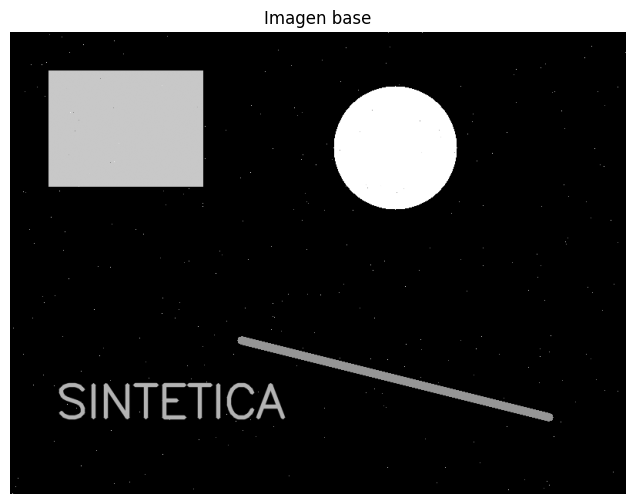

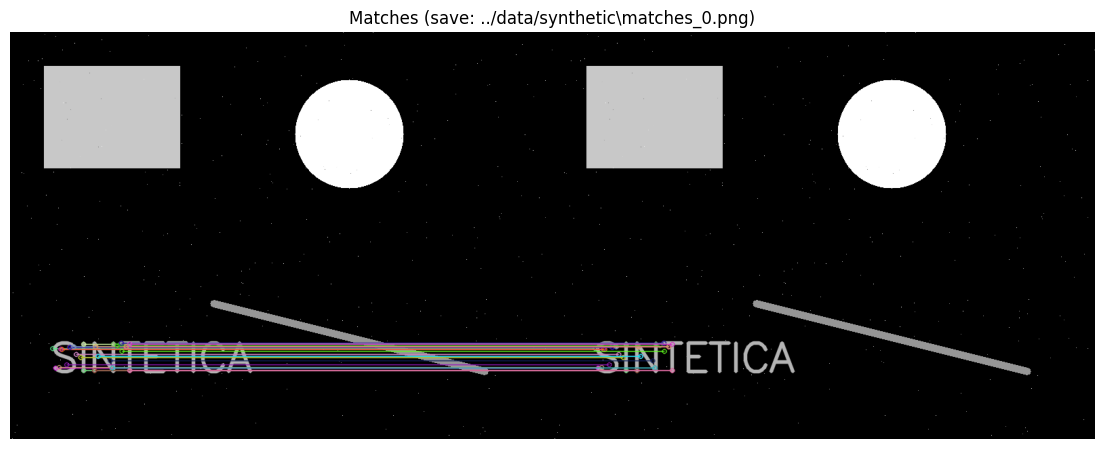

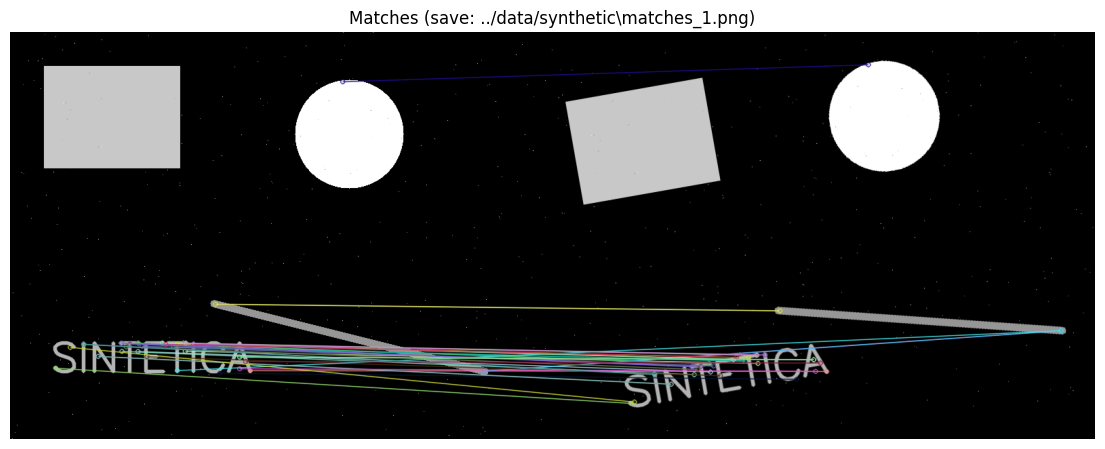

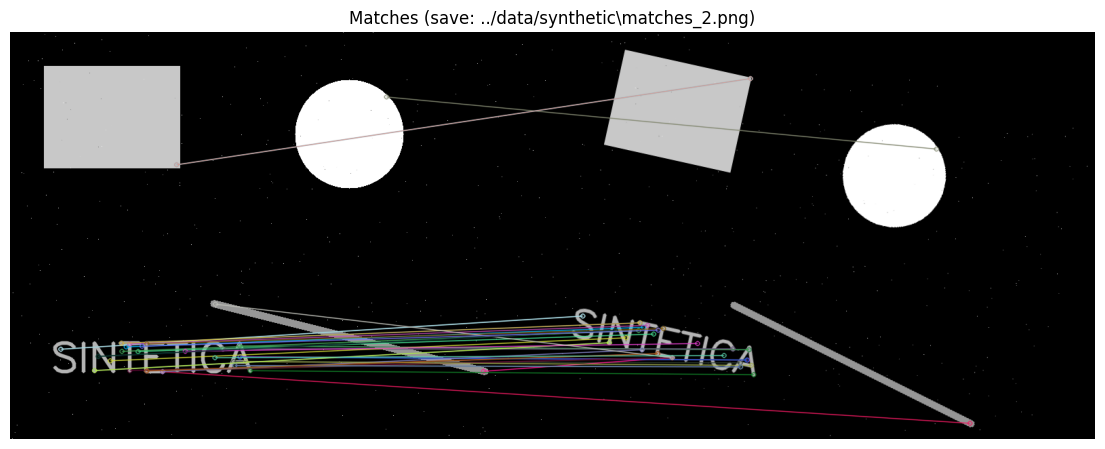

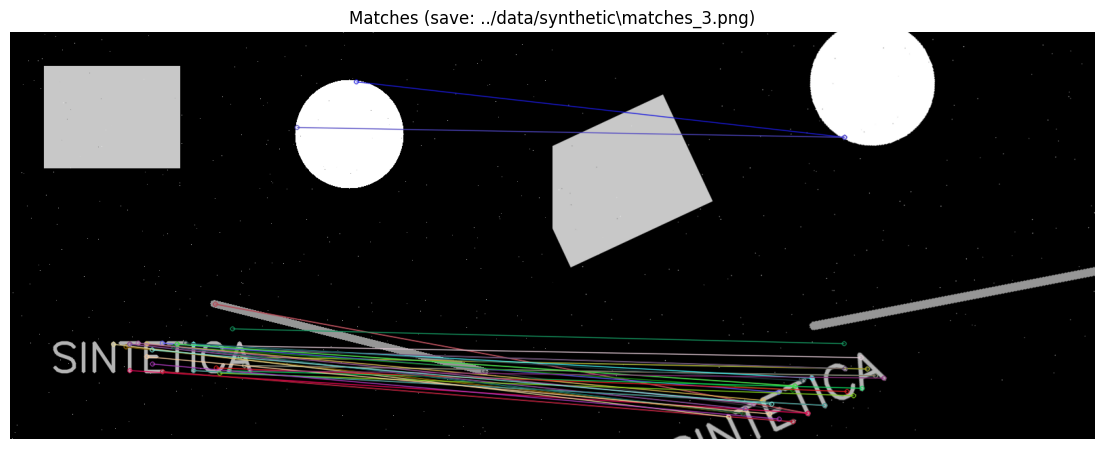

Resultados guardados en: ../data/synthetic\results_summary.csv


id  gt_scale  est_scale  err_scale  gt_angle  est_angle  err_angle  gt_tx  \
0   0      1.00   1.000000   0.000000       0.0   0.000000   0.000000    0.0   
1   1      1.02   1.019824  -0.000176      10.0  -9.947640 -19.947640   15.0   
2   2      0.95   0.950081   0.000081     -12.5  12.487338  24.987338  -20.0   
3   3      1.15   1.149529  -0.000471      25.0 -24.980005 -49.980005   40.0   

       est_tx      err_tx  gt_ty      est_ty      err_ty  num_matches  \
0    0.000000    0.000000    0.0    0.000000    0.000000          152   
1  -39.553381  -54.553381   -8.0   61.356768   69.356768           95   
2   70.678254   90.678254   30.0  -30.469010  -60.469010          103   
3 -122.525518 -162.525518  -20.0  161.883364  181.883364           82   

   num_inliers  rmse_trans                    matches_image  
0          152    0.000000  ../data/synthetic\matches_0.png  
1           88   88.240766  ../data/synthetic\matches_1.png  
2           82  108.991040  ../data/synthetic\matches_2.png  
3           65  243.918228  ../data/synthetic\matches_3.png

In [10]:
# Ejecutar pipeline (main)
base = create_base_image((800,600))
plt.figure(); plt.title('Imagen base'); plt.imshow(base, cmap='gray'); plt.axis('off')

df_results = run_pipeline(base, TRANSFORMS, OUTPUT_DIR)
df_results.style.format(precision=3)
df_results


## Conclusiones

- Se implementó un pipeline reproducible para validar registro usando transformaciones sintéticas con ground-truth.
- El notebook ahora emplea los módulos del paquete (src.feature_detection y src.matching), manejando la no disponibilidad de SIFT mediante fallback a ORB.
- FLANN + Lowe ratio test y RANSAC proveen una estimación robusta de la transformación; las métricas (error en escala, ángulo y traslación) permiten comparar contra el ground-truth.
- Recomendaciones: probar diferentes valores de ratio/RANSAC, enriquecer la escena para obtener más keypoints, y usar homografías si la perspectiva es importante.